# 1. Importing Necessary Libraries


In [ ]:
# After installing restart the kernel 
# !pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  # install dependencies

In [ ]:
# !pip install cufflinks plotly sklearn optuna

In [ ]:
# General
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
import pandas as pd
import os
import numpy as np
from tqdm.notebook import tqdm
import json

# Upload data
import zipfile
import os
from google.colab import drive
from google.colab import files

# Visualization
import matplotlib.pyplot as plt
from IPython.display import clear_output

# OpenCV
import cv2
print(cv2.__version__)

# ScikitLearn for Data Splitting
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

# Optuna
import optuna 

# Pytorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as tr

# Seed Everything for Reproducibility
SEED = 42

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

4.1.2
cuda:0


#2. Load Data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"svetlanapanteleeva","key":"242a5aeeffcc5bc4943c2a01150df794"}'}

In [ ]:
os.environ['KAGGLE_USERNAME'] = "svetlanapanteleeva" # username from the json file
os.environ['KAGGLE_KEY'] = "242a5aeeffcc5bc4943c2a01150df794" # key from the json file
!kaggle datasets download -d mbornoe/lisa-traffic-light-dataset

100% 4.20G/4.21G [02:13<00:00, 31.0MB/s]
100% 4.21G/4.21G [02:13<00:00, 33.8MB/s]


In [ ]:
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=13wwIm9LyGCCvUpuVFb55KFc1YYNifVDr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=13wwIm9LyGCCvUpuVFb55KFc1YYNifVDr" -O data.zip && rm -rf /tmp/cookies.txt

In [ ]:
zip_file = '/content/lisa-traffic-light-dataset.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
os.listdir()

['.config',
 'kaggle.json',
 'nightSequence2',
 'nightTrain',
 'sample-nightClip1',
 'lisa-traffic-light-dataset.zip',
 'dayTrain',
 'Annotations',
 'sample-dayClip6',
 'daySequence2',
 'nightSequence1',
 'daySequence1',
 'sample_data']

# 3. Data Preprocessing

In [ ]:
DAY_TRAIN_PATH ='/content/Annotations/Annotations/dayTrain/'

In [ ]:
train_day = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
    
df = pd.concat(train_day,axis=0)

In [ ]:
df = df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)

In [ ]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,1
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,1
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,2
5,dayTraining/dayClip1--00002.jpg,go,848,389,860,409,2
6,dayTraining/dayClip1--00003.jpg,go,698,329,710,354,3
7,dayTraining/dayClip1--00003.jpg,go,850,383,862,408,3
8,dayTraining/dayClip1--00004.jpg,go,697,328,712,353,4
9,dayTraining/dayClip1--00004.jpg,go,852,383,864,408,4


In [ ]:
def changeFilename(x):
    filename = x.Filename
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
   
    return os.path.join(zip_file,f'/content/dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [ ]:
df['Annotation tag'].unique()

array(['go', 'stop', 'stopLeft', 'warning', 'goLeft', 'warningLeft'],
      dtype=object)

In [ ]:
label_to_idx = {'go':0, 'warning':1, 'stop': 2}
idx_to_label = {v:k for k,v in label_to_idx.items()}

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']
    
df['Annotation tag'] = df.apply(changeAnnotation,axis=1)

annotation_tags = df['Annotation tag'].unique()
annotation_tags

array([0, 2, 1])

In [ ]:
df.columns = ['image_id','label','x_min','y_min','x_max','y_max','frame']

In [ ]:
print("Number of Unique Images: ",df.image_id.nunique(),'/',df.shape[0])

Number of Unique Images:  12775 / 37810


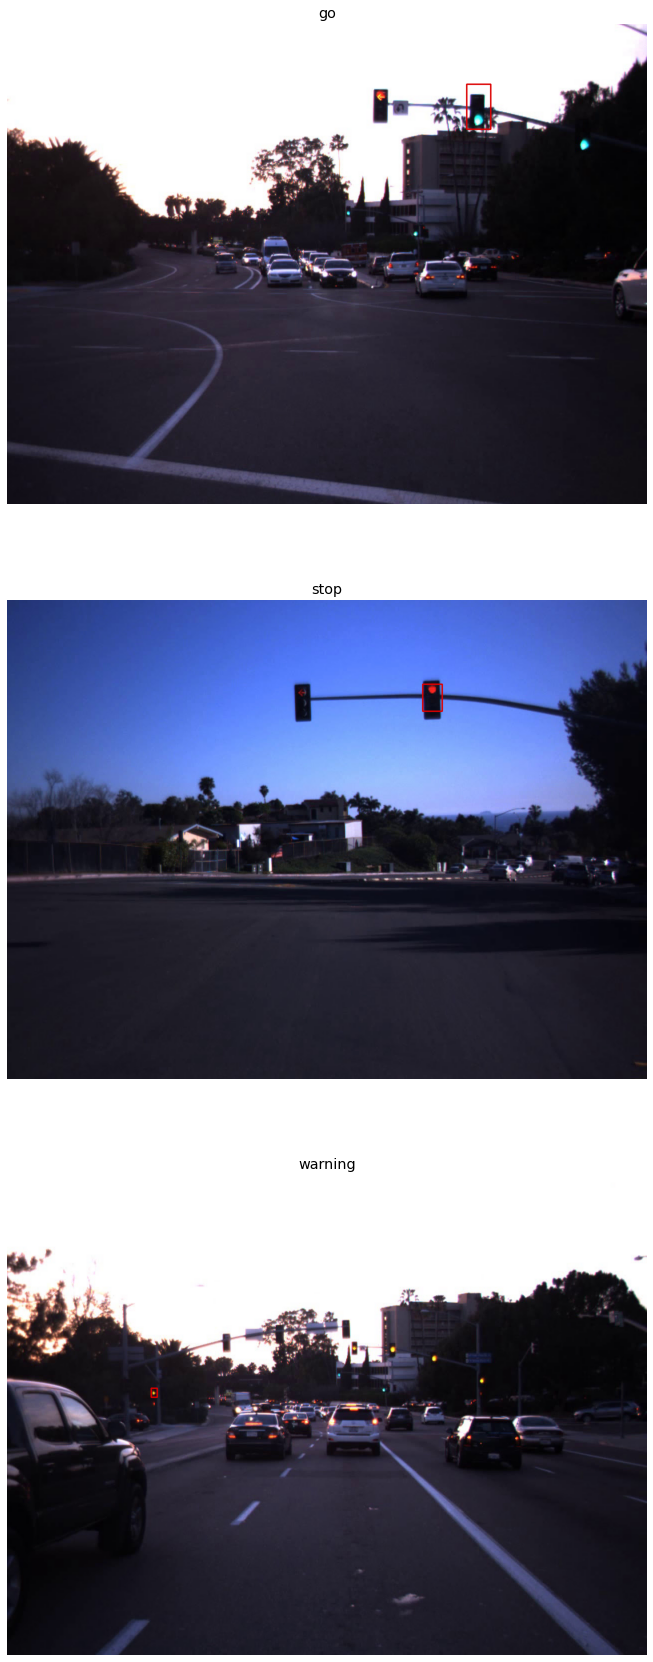

In [ ]:
fig, ax = plt.subplots(len(annotation_tags),1,figsize=(15,10*len(annotation_tags)))

for i, tag in enumerate(annotation_tags):
    sample = df[df['label']==tag].sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]
    
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)
    
    ax[i].set_title(idx_to_label[tag])
    ax[i].set_axis_off()
    ax[i].imshow(image)

In [ ]:
df['clipNames'] = df[['image_id']].applymap(lambda x: x.split('/')[4])
df['clipNames'].unique()

array(['dayClip1', 'dayClip10', 'dayClip11', 'dayClip12', 'dayClip13',
       'dayClip2', 'dayClip3', 'dayClip4', 'dayClip5', 'dayClip6',
       'dayClip7', 'dayClip8', 'dayClip9'], dtype=object)

In [ ]:
df.head(10)

,image_id,label,x_min,y_min,x_max,y_max,frame,clipNames
0,/content/dayTrain/dayTrain/dayClip1/frames/day...,0,698,333,710,358,0,dayClip1
1,/content/dayTrain/dayTrain/dayClip1/frames/day...,0,846,391,858,411,0,dayClip1
2,/content/dayTrain/dayTrain/dayClip1/frames/day...,0,698,337,710,357,1,dayClip1
3,/content/dayTrain/dayTrain/dayClip1/frames/day...,0,847,390,859,410,1,dayClip1
4,/content/dayTrain/dayTrain/dayClip1/frames/day...,0,698,331,710,356,2,dayClip1
5,/content/dayTrain/dayTrain/dayClip1/frames/day...,0,848,389,860,409,2,dayClip1
6,/content/dayTrain/dayTrain/dayClip1/frames/day...,0,698,329,710,354,3,dayClip1
7,/content/dayTrain/dayTrain/dayClip1/frames/day...,0,850,383,862,408,3,dayClip1
8,/content/dayTrain/dayTrain/dayClip1/frames/day...,0,697,328,712,353,4,dayClip1
9,/content/dayTrain/dayTrain/dayClip1/frames/day...,0,852,383,864,408,4,dayClip1


In [ ]:
def split(df,p=0.25):
    clipNames = sorted(df['clipNames'].unique())

    dayClips = [name for name in clipNames if 'day' in name]

    testDayClipNames = list(np.random.choice(dayClips,int(len(dayClips)*p)))
    testClipNames = testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainClipNames = trainDayClipNames
    
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df

In [ ]:
train_df, test_df = split(df)
print("Train shape: ",train_df.shape)
print("Test shape: ",test_df.shape)

Train shape:  (24683, 8)
Test shape:  (13127, 8)


# 4. Custom dataset

In [ ]:
class TrafficLightsDataset:
    def __init__(self, df, transforms=None):
        super().__init__()
        # Image_ids will be the "Filename" here
        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df.image_id == image_id]

        # Reading Image
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # Bounding Boxes
        boxes = records[['x_min','y_min','x_max','y_max']].values
        ind = np.random.randint(len(boxes))
        image = image[boxes[ind,1]:boxes[ind,3], boxes[ind,0]:boxes[ind,2]]
        boxes = torch.as_tensor(boxes,dtype=torch.float32)

        # Labels of the object detected
        labels = torch.as_tensor(records.label.values, dtype=torch.int64)

        if self.transforms:
            image = self.transforms(image)
            target = labels[ind]           
        return image, target



In [ ]:
# For Train Data
def getTrainTransform():
    return tr.Compose([
        tr.ToTensor(),
        tr.Resize((64, 32)),
        tr.RandomHorizontalFlip(0.5)
    ])
    
# For Test Data
def getTestTransform():
    return tr.Compose([
        tr.ToTensor(),
        tr.Resize((64, 32))
    ])

In [ ]:
trainDataset = TrafficLightsDataset(train_df,getTrainTransform())
testDataset = TrafficLightsDataset(test_df,getTestTransform())

In [ ]:
BATCH_SIZE = 32

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
trainDataLoader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

testDataLoader = DataLoader(
    testDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# 5. Creating model

In [ ]:
# 64x32x3 --> 32x16x16 --> 16x8x32 --> 8x4x64 --> 4x2x128 ~ 1024 --> hid_size --> 4
class class_head(nn.Module):
    def __init__(self, conv_blocks=4, ch_out=16, hid_size=32):
        super(class_head, self).__init__()

        self.convs = [nn.Conv2d(3, ch_out, 3, padding=1)] + [nn.Conv2d(ch_out * 2**i, ch_out * 2**(i+1), 3, padding=1) for i in range(conv_blocks-1)]
        self.bns = [nn.BatchNorm2d(ch_out * 2**i) for i in range(conv_blocks)]
        self.acts = [nn.LeakyReLU(0.2) for i in range(conv_blocks)]
        self.pools = [nn.MaxPool2d(2) for i in range(conv_blocks)]

        self.conv_blocks = [[(f'conv_{i}', self.convs[i]),
                             (f'bn_{i}', self.bns[i]),
                             (f'act_{i}', self.acts[i]),
                             (f'pool_{i}', self.pools[i])] for i in range(conv_blocks)]
        
        self.full_convs = []
        for block in self.conv_blocks:
            self.full_convs.extend(block)
        self.full_convs = nn.Sequential(OrderedDict(self.full_convs))


        self.head = [('flatten', nn.Flatten()),
                     ('drop', nn.Dropout(0.4)),
                     ('hid_lin', nn.Linear(ch_out * 2**(10 - conv_blocks), hid_size)),
                     ('hid_act', nn.LeakyReLU(0.2)),
                     ('head_lin', nn.Linear(hid_size, 3)),
                     ('head_act', nn.Softmax())]
        self.head = nn.Sequential(OrderedDict(self.head))
    
    def forward(self, imgs):
        out = self.full_convs(imgs)
        out = self.head(out)
        return out

In [ ]:
def create_model_and_optimizer(device, conv_blocks=4, ch_out=16, hid_size=32, lr = 0.0001, beta1 = 0.9, beta2 = 0.999):
    model = class_head(conv_blocks, ch_out, hid_size)
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr, [beta1, beta2])
    return model, optimizer

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model, optimizer = create_model_and_optimizer(device, conv_blocks=4, ch_out=16, hid_size=32)

# 6. Train and Experiments



## First train without Optuna




In [ ]:
def train(model, optimizer, loader):
    model.train()

    losses_tr = []
    correct = 0
    for images, targets in tqdm(loader):
        images = torch.stack(images).to(device)
        targets = torch.stack(targets).to(device)
        
        optimizer.zero_grad()
        out = model(images)
        loss = F.nll_loss(out, targets)
        _, pred = torch.max(out.data, 1)
        correct += pred.eq(targets.view_as(pred)).sum().item()
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    
    return np.mean(losses_tr), correct / len(loader.dataset)

def val(model, loader):
    model.eval()
    losses_val = []
    correct = 0
    with torch.no_grad():
        for images, targets in tqdm(loader):
            images = torch.stack(images).to(device)
            targets = torch.stack(targets).to(device)
            out = model(images)
            loss = F.nll_loss(out, targets)
            _, pred = torch.max(out.data, 1)
            correct += pred.eq(targets.view_as(pred)).sum().item()
            total = len(loader.dataset)

            losses_val.append(loss.item())
    
    return np.mean(losses_val), correct / len(loader.dataset)

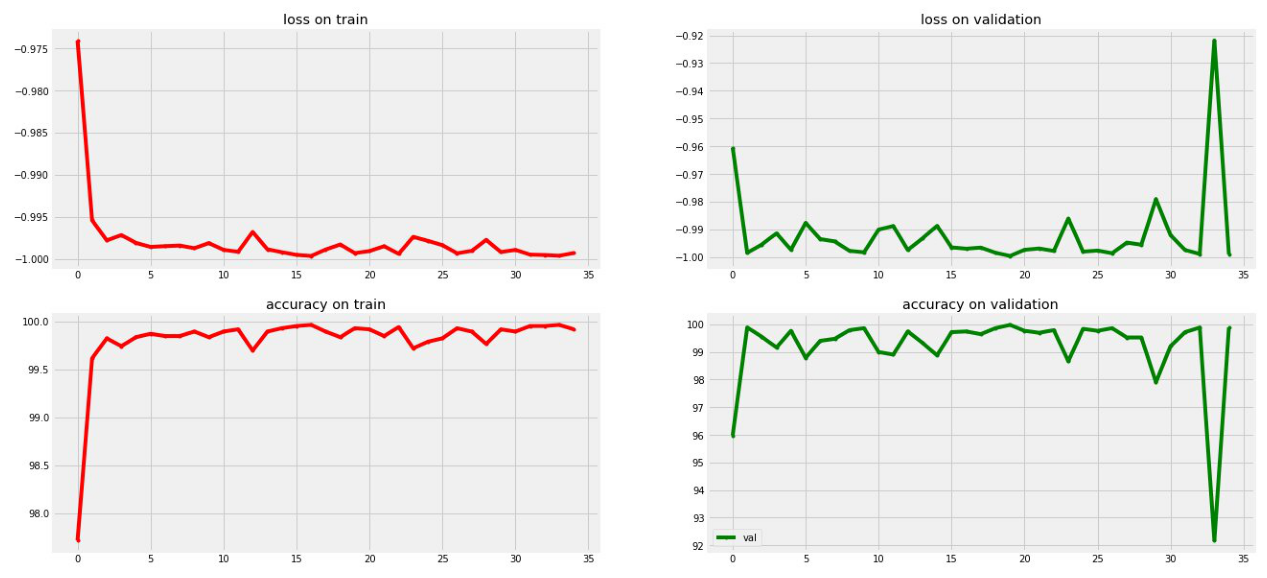

Epoch: 34 / 100, Accuracy: 99.99%


In [ ]:
epochs = 100

model, optimizer = create_model_and_optimizer(device, conv_blocks=4, ch_out=16, hid_size=32)
losses = {'train': [], 'val': []}
accuracy = {'train': [], 'val': []}

for epoch in range(1, epochs+1):
    model, optimizer, loss, acc = train(model, optimizer, trainDataLoader)
    losses['train'].append(loss)
    accuracy['train'].append(acc * 100)
    
    loss, acc = val(model, testDataLoader)
    losses['val'].append(loss)
    accuracy['val'].append(acc * 100)

    if not (epoch % 1):
        clear_output(True)
        fig, ax = plt.subplots(1, 4, figsize=(20, 10))
        
        plt.subplot(221)
        plt.plot(losses['train'], 'r.-', label='train')
        plt.title('loss on train')

        plt.subplot(222)
        plt.plot(losses['val'], 'g.-', label='val')
        plt.title('loss on validation')

        plt.subplot(223)
        plt.plot([int(i) for i in range(1, epoch+1)], accuracy['train'], 'r.-', label='train')
        plt.title('accuracy on train')

        plt.subplot(224)
        plt.plot([int(i) for i in range(1, epoch+1)], accuracy['val'], 'g.-', label='val')
        plt.title('accuracy on validation')

        plt.legend()
        plt.show()

    print('Epoch: {} / {}, Accuracy: {:.2f}%'.format(epoch, epochs, accuracy['val'][epoch-1]))

    if epoch > 10 and accuracy['val'][epoch] < 93:
      break

    torch.save(model.state_dict(), 'S&P_{}.pt'.format(epoch))

    if epoch > 10 and accuracy['val'][epoch] >= 99:
      break

Model seems to be inadequate and overfitted.

##Experiments witn Optuna

### 1.Tune parametrs of model, batch size and lerning rate  

In [ ]:
def objective(trial):

  # Number of convolutional blocks
  conv_blocks = trial.suggest_int("conv_blocks", 1, 5, 1)
  ch_out = trial.suggest_categorical("ch_out", [8, 16, 32, 64])
  hid_size = trial.suggest_categorical("hid_size",[16, 32, 64, 128, 256])
  model = class_head(conv_blocks, ch_out, hid_size).to(device)


  # Batch size
  batch = trial.suggest_categorical('batchsize', [16, 32, 64])
  trainDataLoader = DataLoader(trainDataset, batch_size=batch, shuffle=True, num_workers=4, collate_fn=collate_fn)
  testDataLoader = DataLoader(testDataset, batch_size=batch, shuffle=False, num_workers=4, collate_fn=collate_fn)


  # Lerning rate
  lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  lr_factor = trial.suggest_float("lr_factor", 0.1, 0.5, log=True)
  lr_patience = trial.suggest_int("lr_patience", 4, 8, 2)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                           factor=lr_factor, patience=lr_patience)
  
  best_acc = 0.0
  acc_not_improved_counter = 0
  for epoch in range(epochs):
    loss, train_acc = train(model, optimizer, trainDataLoader)
    loss, test_acc = val(model, testDataLoader)
    scheduler.step(test_acc)
    if test_acc > best_acc:
        best_acc = test_acc
        acc_not_improved_counter = 0
    else:
        acc_not_improved_counter += 1
        if acc_not_improved_counter > lr_patience*2 + 2:
            break
    return best_acc

In [ ]:
epochs = 20
timeout_hours = 10
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=3600*timeout_hours)

[I 2021-04-01 14:22:42,768] A new study created in memory with name: no-name-87cbeb66-0e96-4ca4-86f5-a79f354a502b


[I 2021-04-01 14:27:12,848] Trial 0 finished with value: 0.9383070301291249 and parameters: {'conv_blocks': 3, 'ch_out': 8, 'hid_size': 32, 'batchsize': 64, 'lr': 2.676167038880134e-05, 'lr_factor': 0.21896118459087424, 'lr_patience': 6}. Best is trial 0 with value: 0.9383070301291249.


[I 2021-04-01 14:31:48,778] Trial 1 finished with value: 0.9813486370157819 and parameters: {'conv_blocks': 2, 'ch_out': 8, 'hid_size': 64, 'batchsize': 16, 'lr': 3.478816520096598e-05, 'lr_factor': 0.18622998140681932, 'lr_patience': 6}. Best is trial 1 with value: 0.9813486370157819.


[I 2021-04-01 14:36:31,163] Trial 2 finished with value: 0.9450023912003825 and parameters: {'conv_blocks': 1, 'ch_out': 64, 'hid_size': 128, 'batchsize': 16, 'lr': 0.00010442286742024706, 'lr_factor': 0.45333871292392824, 'lr_patience': 8}. Best is trial 1 with value: 0.9813486370157819.


[I 2021-04-01 14:41:17,834] Trial 3 finished with value: 0.9923481587757054 and parameters: {'conv_blocks': 2, 'ch_out': 32, 'hid_size': 16, 'batchsize': 16, 'lr': 3.356257296032524e-05, 'lr_factor': 0.19363990378402543, 'lr_patience': 8}. Best is trial 3 with value: 0.9923481587757054.


[I 2021-04-01 14:46:02,093] Trial 4 finished with value: 0.9638928742228599 and parameters: {'conv_blocks': 5, 'ch_out': 16, 'hid_size': 256, 'batchsize': 64, 'lr': 1.5171781418965917e-05, 'lr_factor': 0.2927460488556307, 'lr_patience': 6}. Best is trial 3 with value: 0.9923481587757054.


[I 2021-04-01 14:50:47,805] Trial 5 finished with value: 0.9660449545671927 and parameters: {'conv_blocks': 3, 'ch_out': 64, 'hid_size': 128, 'batchsize': 32, 'lr': 0.0001141503940590804, 'lr_factor': 0.1469121792568393, 'lr_patience': 4}. Best is trial 3 with value: 0.9923481587757054.


[I 2021-04-01 14:55:32,598] Trial 6 finished with value: 0.968675274988044 and parameters: {'conv_blocks': 3, 'ch_out': 64, 'hid_size': 32, 'batchsize': 32, 'lr': 1.500001403930271e-05, 'lr_factor': 0.49461582200399656, 'lr_patience': 4}. Best is trial 3 with value: 0.9923481587757054.


[I 2021-04-01 15:00:15,029] Trial 7 finished with value: 0.6592539454806313 and parameters: {'conv_blocks': 1, 'ch_out': 64, 'hid_size': 64, 'batchsize': 32, 'lr': 0.0071895922140444565, 'lr_factor': 0.3701854243149896, 'lr_patience': 4}. Best is trial 3 with value: 0.9923481587757054.


[I 2021-04-01 15:04:57,774] Trial 8 finished with value: 0.9583931133428981 and parameters: {'conv_blocks': 2, 'ch_out': 32, 'hid_size': 32, 'batchsize': 64, 'lr': 1.6589714901215012e-05, 'lr_factor': 0.40102610193919525, 'lr_patience': 8}. Best is trial 3 with value: 0.9923481587757054.


[I 2021-04-01 15:09:43,898] Trial 9 finished with value: 0.9538498326159732 and parameters: {'conv_blocks': 1, 'ch_out': 64, 'hid_size': 256, 'batchsize': 64, 'lr': 0.000489550869949763, 'lr_factor': 0.17511757462988758, 'lr_patience': 4}. Best is trial 3 with value: 0.9923481587757054.


In [ ]:
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  10
  Number of complete trials:  10
Best trial:
  Value:  0.9923481587757054
  Params: 
    conv_blocks: 2
    ch_out: 32
    hid_size: 16
    batchsize: 16
    lr: 3.356257296032524e-05
    lr_factor: 0.19363990378402543
    lr_patience: 8


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  10
  Number of complete trials:  10
Best trial:
  Value:  0.9952175992348159
  Params: 
    conv_blocks: 4
    ch_out: 16
    hid_size: 16
    batchsize: 16
    lr: 0.0003947765412364498
    lr_factor: 0.2953141965021283
    lr_patience: 4


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

### 2.Tune parametrs of model, batch size,  lerning rate and optimizer

In [ ]:
def objective(trial):

  # Number of convolutional blocks
  conv_blocks = trial.suggest_int("conv_blocks", 1, 5, 1)
  ch_out = trial.suggest_categorical("ch_out", [8, 16, 32, 64])
  hid_size = trial.suggest_categorical("hid_size",[16, 32, 64, 128, 256])
  model = class_head(conv_blocks, ch_out, hid_size).to(device)


  # Batch size
  batch = trial.suggest_categorical('batchsize', [16, 32, 64])
  trainDataLoader = DataLoader(trainDataset, batch_size=batch, shuffle=True, num_workers=4, collate_fn=collate_fn)
  testDataLoader = DataLoader(testDataset, batch_size=batch, shuffle=False, num_workers=4, collate_fn=collate_fn)


  # Lerning rate
  lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  lr_factor = trial.suggest_float("lr_factor", 0.1, 0.5, log=True)
  lr_patience = trial.suggest_int("lr_patience", 4, 8, 2)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                           factor=lr_factor, patience=lr_patience)

  
  # Optimizer
  optimizer_category = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
  if optimizer_category == "Adam":
      # beta1 = trial.suggest_float("beta1", 0.25, 1, 0.25 )
      # beta2 = trial.suggest_categorical("beta2", [0.9, 0.99, 0.999])
      optimizer = torch.optim.Adam(model.parameters(), lr)#, betas=(beta1, beta2))
  else:
      m = trial.suggest_float("momentum", 0.0, 1.0)# *, 0.05, log = False) #step = 0.05
      w = trial.suggest_float("weight_decay", 0.25, 1.0)#, *, 0.25, log=False) #step = 0.25["0.000125", "0.00025", "0.0005"]
      optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=m, weight_decay=w*0.0005, nesterov=True)

  
  best_acc = 0.0
  acc_not_improved_counter = 0
  for epoch in range(epochs):
    loss, train_acc = train(model, optimizer, trainDataLoader)
    loss, test_acc = val(model, testDataLoader)
    scheduler.step(test_acc)
    if test_acc > best_acc:
        best_acc = test_acc
        acc_not_improved_counter = 0
    else:
        acc_not_improved_counter += 1
        if acc_not_improved_counter > lr_patience*2 + 2:
            break
    return best_acc

In [ ]:
epochs = 20
timeout_hours = 10
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=3600*timeout_hours)

[I 2021-04-01 18:08:04,419] A new study created in memory with name: no-name-29f2bdd6-a063-406d-b52c-2c1b7ee44fb1


[I 2021-04-01 18:12:41,772] Trial 0 finished with value: 0.7173601147776184 and parameters: {'conv_blocks': 4, 'ch_out': 8, 'hid_size': 16, 'batchsize': 32, 'lr': 1.5442406058244563e-05, 'lr_factor': 0.1273696610962344, 'lr_patience': 4, 'optimizer': 'SGD', 'momentum': 0.9076496680225273, 'weight_decay': 0.6811075527145811}. Best is trial 0 with value: 0.7173601147776184.


[I 2021-04-01 18:17:22,129] Trial 1 finished with value: 0.9952175992348159 and parameters: {'conv_blocks': 1, 'ch_out': 16, 'hid_size': 256, 'batchsize': 16, 'lr': 0.00012484125769088617, 'lr_factor': 0.13325486000996511, 'lr_patience': 4, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.9952175992348159.


[I 2021-04-01 18:21:57,563] Trial 2 finished with value: 0.7345767575322812 and parameters: {'conv_blocks': 2, 'ch_out': 64, 'hid_size': 32, 'batchsize': 32, 'lr': 2.0856646886899395e-05, 'lr_factor': 0.357965007392882, 'lr_patience': 6, 'optimizer': 'SGD', 'momentum': 0.4249703628105408, 'weight_decay': 0.781418409502927}. Best is trial 1 with value: 0.9952175992348159.


[I 2021-04-01 18:26:28,859] Trial 3 finished with value: 0.9849354375896701 and parameters: {'conv_blocks': 1, 'ch_out': 16, 'hid_size': 128, 'batchsize': 32, 'lr': 0.0004113632421096856, 'lr_factor': 0.16580614695120036, 'lr_patience': 6, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.9952175992348159.


[I 2021-04-01 18:31:02,257] Trial 4 finished with value: 0.6523194643711143 and parameters: {'conv_blocks': 3, 'ch_out': 32, 'hid_size': 32, 'batchsize': 32, 'lr': 1.171143825213048e-05, 'lr_factor': 0.20922920466463815, 'lr_patience': 8, 'optimizer': 'SGD', 'momentum': 0.7945075493190713, 'weight_decay': 0.8186530233929843}. Best is trial 1 with value: 0.9952175992348159.


[I 2021-04-01 18:35:34,255] Trial 5 finished with value: 0.9670014347202296 and parameters: {'conv_blocks': 2, 'ch_out': 8, 'hid_size': 256, 'batchsize': 64, 'lr': 0.0016366086643016039, 'lr_factor': 0.28127260172067664, 'lr_patience': 4, 'optimizer': 'SGD', 'momentum': 0.9701303538092352, 'weight_decay': 0.9199927157080566}. Best is trial 1 with value: 0.9952175992348159.


[I 2021-04-01 18:40:08,720] Trial 6 finished with value: 0.9588713534194165 and parameters: {'conv_blocks': 4, 'ch_out': 16, 'hid_size': 16, 'batchsize': 32, 'lr': 0.002630415845297837, 'lr_factor': 0.3086068790141605, 'lr_patience': 8, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.9952175992348159.


[I 2021-04-01 18:44:50,278] Trial 7 finished with value: 0.9844571975131516 and parameters: {'conv_blocks': 4, 'ch_out': 64, 'hid_size': 16, 'batchsize': 16, 'lr': 0.008093899069447961, 'lr_factor': 0.2584269691407841, 'lr_patience': 6, 'optimizer': 'SGD', 'momentum': 0.45905789533931707, 'weight_decay': 0.7657465890135907}. Best is trial 1 with value: 0.9952175992348159.


[I 2021-04-01 18:49:26,291] Trial 8 finished with value: 0.9648493543758967 and parameters: {'conv_blocks': 4, 'ch_out': 64, 'hid_size': 256, 'batchsize': 32, 'lr': 0.004614464683189248, 'lr_factor': 0.43953869431765413, 'lr_patience': 4, 'optimizer': 'SGD', 'momentum': 0.0748546195756713, 'weight_decay': 0.741150492798811}. Best is trial 1 with value: 0.9952175992348159.


[I 2021-04-01 18:54:01,314] Trial 9 finished with value: 0.9823051171688187 and parameters: {'conv_blocks': 1, 'ch_out': 8, 'hid_size': 128, 'batchsize': 32, 'lr': 0.0017079115413181126, 'lr_factor': 0.30207480489319505, 'lr_patience': 8, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.9952175992348159.


In [ ]:
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  10
  Number of complete trials:  10
Best trial:
  Value:  0.9952175992348159
  Params: 
    conv_blocks: 1
    ch_out: 16
    hid_size: 256
    batchsize: 16
    lr: 0.00012484125769088617
    lr_factor: 0.13325486000996511
    lr_patience: 4
    optimizer: Adam


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

## Final train with best parametrs

In [ ]:
def create_model_and_optimizer(device, conv_blocks=1, ch_out=16, hid_size=256, lr = 0.00012484125769088617, beta1 = 0.9, beta2 = 0.999):
    model = class_head(conv_blocks, ch_out, hid_size)
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr, [beta1, beta2])
    return model, optimizer

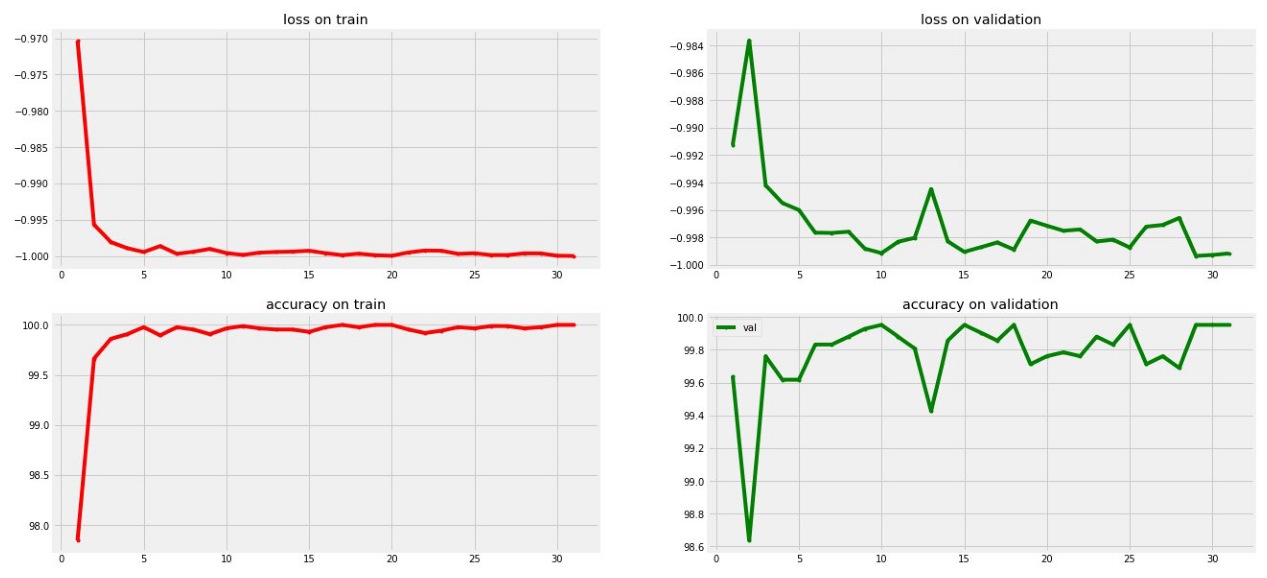

Epoch: 31 / 100, Accuracy: 99.90%


In [ ]:
epochs = 100
lr_factor = 0.13325486000996511
lr_patience = 4

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                           factor=lr_factor, patience=lr_patience)

model, optimizer = create_model_and_optimizer(device, conv_blocks=4, ch_out=16, hid_size=32)
losses = {'train': [], 'val': []}
accuracy = {'train': [], 'val': []}

for epoch in range(1, epochs+1):
    loss, acc = train(model, optimizer, trainDataLoader)
    losses['train'].append(loss)
    accuracy['train'].append(acc * 100)
    
    loss, acc = val(model, testDataLoader)
    losses['val'].append(loss)
    accuracy['val'].append(acc * 100)

    if not (epoch % 1):
        clear_output(True)
        fig, ax = plt.subplots(1, 4, figsize=(20, 10))
        
        plt.subplot(221)
        plt.plot([int(i) for i in range(1, epoch+1)], losses['train'], 'r.-', label='train')
        plt.title('loss on train')

        plt.subplot(222)
        plt.plot([int(i) for i in range(1, epoch+1)], losses['val'], 'g.-', label='val')
        plt.title('loss on validation')

        plt.subplot(223)
        plt.plot([int(i) for i in range(1, epoch+1)], accuracy['train'], 'r.-', label='train')
        plt.title('accuracy on train')

        plt.subplot(224)
        plt.plot([int(i) for i in range(1, epoch+1)], accuracy['val'], 'g.-', label='val')
        plt.title('accuracy on validation')

        plt.legend()
        plt.show()

    print('Epoch: {} / {}, Accuracy: {:.2f}%'.format(epoch, epochs, accuracy['val'][epoch-1]))

    best_acc = 0.0
    acc_not_improved_counter = 0

    scheduler.step(acc)

    # Early stopping
    if acc > best_acc:
        best_acc = acc
        acc_not_improved_counter = 0
    else:
        acc_not_improved_counter += 1
        if acc_not_improved_counter > lr_patience * 2 + 2:
            break

    torch.save(model.state_dict(), 'S&P_{}.pt'.format(epoch))

# 7. Evaluation model on video

In [ ]:
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s')
yolo.classes = 9

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672



Adding autoShape... 


YOLOv5 🚀 2021-4-1 torch 1.8.1+cu101 CPU



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
weights_path = '/content/drive/MyDrive/S&P_10.pt'
classifier = class_head()
classifier.load_state_dict(torch.load(weights_path))

In [ ]:
def predict_video(video_path, save_path):
    %%time

    labels_to_class = {}
    labels_to_class[0] = 'Green'
    labels_to_class[1] = 'Red'
    labels_to_class[2] = 'Yellow/Unknown'

    device = torch.device('cuda')
    yolo.eval()

    frame_array = []
    count = 0
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    success,image = cap.read()

    while cap.isOpened():
      success, image = cap.read()
      if success:
          height, width, _ = image.shape
          size = (width,height)

          with torch.no_grad():
              predictions = yolo(image).pred[0].cpu().detach().numpy()
              n_bboxes = predictions.shape[0]
              labels = []
              bboxes = []
              for i in range(n_bboxes):
                  if predictions[i][4] > 0.5: # changeable threshold
                      bbox = predictions[i][:4].astype(np.uint16)
                      bboxes.append(bbox)
                      img_cropped = image[bbox[1]:bbox[3],bbox[0]:bbox[2],:].copy()
                      label = classifier(torch.as_tensor([cv2.resize(img_cropped, (32,64)).transpose((2,0,1)) / 255]).float())
                      labels.append(np.argmax(label.cpu().detach().numpy()))     

          for i in range(len(bboxes)):
              bbox = bboxes[i]
              label = labels_to_class[labels[i]]
              image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (36,255,12), 2)
              image = cv2.putText(image, label, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
          frame_array.append(image)
      else:
          break
      count += 1
      # print(count)
    print('number of frame in video', count)
    print('frame per second', fps)

    out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(frame_array)):
        out.write(frame_array[i]) # writing to a image array
    out.release()
    return

In [ ]:
video_path = '/content/drive/MyDrive/video_0.mp4'
save_path = '/content/drive/MyDrive/video_0_predict.mp4'
predict_video(video_path, save_path)

# 8. Make json file

In [ ]:
labels_to_class = {}
labels_to_class[0] = 'green'
labels_to_class[1] = 'red'
labels_to_class[2] = 'yellow/unknown'


device = torch.device('cuda')
yolo.eval()

count = 0
result = {}
tr_str = 'traffic_light_'

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
success,image = cap.read()

while cap.isOpened():  
    success, image = cap.read()
    if success:
        height, width, _ = image.shape
        size = (width,height)  
            
        traffic_lights = {}

        with torch.no_grad():
            predictions = yolo(image).pred[0].cpu().detach().numpy()
            n_bboxes = predictions.shape[0]
            labels = []
            bboxes = []
            for i in range(n_bboxes):
                if predictions[i][4] > 0.3: 
                    bbox = predictions[i][:4].astype(np.uint16)
                    bboxes.append(bbox)
                    img_cropped = image[bbox[1]:bbox[3],bbox[0]:bbox[2],:].copy()
                    label = classifier(torch.as_tensor([cv2.resize(img_cropped, (32,64)).transpose((2,0,1)) / 255]).float())
                    labels.append(np.argmax(label.cpu().detach().numpy()))
            for i in range(len(bboxes)):
                tl_dict = {}
                tl_dict['coords'] = bboxes[i]
                tl_dict['state'] = labels_to_class[labels[i]]
                tl_dict['affect'] = True
                traffic_lights[tr_str+str(i)] = tl_dict
            result[str(count)] = traffic_lights
    else:
      break
    count += 1

In [ ]:
result

In [ ]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

dumped = json.dumps(result, cls=NumpyEncoder)

with open('/content/drive/MyDrive/results.json', 'w') as f:
    json.dump(dumped, f)

In [ ]:
with open('/content/drive/MyDrive/results.json', 'r') as f:
  data = json.load(f)
  results = json.loads(data)